# DA Humi Gadget in Housing Response Time RH

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statistics import mean
#from quickplot import QuickPlot

import sensirion_fastedf as fastedf
import datetime
import data_access as da
import csv
import math
from scipy.optimize import curve_fit

In [2]:
amb1 = fastedf.read_edf(r'/home/jovyan/LABDATA/FAE/Humi_Gadget_Housing/ResponseTime_RH/2022-10-05_16-41-39-SHT4x_279916703.edf')
amb2 = fastedf.read_edf(r'/home/jovyan/LABDATA/FAE/Humi_Gadget_Housing/ResponseTime_RH/2022-10-05_16-41-39-SHT4x_279922293.edf')
DM = fastedf.read_edf(r'/home/jovyan/LABDATA/FAE/Humi_Gadget_Housing/ResponseTime_RH/20221005T144129Z_dmeiThunderMeas_HumiGadget_Resp_RH/20221005T144145Z_dmeiThunderMeas_HumiGadget_Resp_RHT24C/20221005T144145Z_DPM373_DewPointMirror.edf')

HumiGadget = fastedf.read_edf(r'/home/jovyan/LABDATA/FAE/Humi_Gadget_Housing/ResponseTime_RH/Sensirion-MyAmbience-2022-10-06T10-03-03.579516/Sensirion_MyAmbience_SHT40_Gadget_9D56_2022-10-06T10-06-23.621890.edf')
HumiGadgetbare = fastedf.read_edf(r'/home/jovyan/LABDATA/FAE/Humi_Gadget_Housing/ResponseTime_RH/Sensirion-MyAmbience-2022-10-06T10-03-03.579516/Sensirion_MyAmbience_SHT40_Gadget_F109_2022-10-06T10-03-03.580430.edf')
# amb1.head()

# HumiGadget.RH.plot()
# print(HumiGadget)

start = datetime.datetime(2022,9,27,7,13).timestamp() # from amb1 starting measurement
start = amb1.Epoch_UTC[0] + 11*60*60 # shifted by three hours since in the beginning it needed to adjust to the thunder
# print(start)

HumiGadget.Epoch_UTC = HumiGadget.Epoch_UTC - start
HumiGadgetbare.Epoch_UTC = HumiGadgetbare.Epoch_UTC - start
amb1.Epoch_UTC = amb1.Epoch_UTC - start
amb2.Epoch_UTC = amb2.Epoch_UTC - start
DM.Epoch_UTC = DM.Epoch_UTC - start
# print(HumiGadget)
HumiGadget = HumiGadget.where(HumiGadget.Epoch_UTC > 0).dropna()
HumiGadgetbare = HumiGadgetbare.where(HumiGadgetbare.Epoch_UTC > 0).dropna()
amb1 = amb1.where(amb1.Epoch_UTC > 0).dropna()
amb2 = amb2.where(amb2.Epoch_UTC > 0).dropna()
DM = DM.where(DM.Epoch_UTC > 0).dropna()
print(HumiGadget.head())
print(HumiGadget.iloc[1,0])
# print(amb2.head())

       Epoch_UTC             Local_Date_Time       T      RH
97009        1.9  2022-10-06T03:41:41.554330  23.809  64.884
97010        3.9  2022-10-06T03:41:43.554336  23.804  64.848
97011        5.9  2022-10-06T03:41:45.554727  23.798  64.869
97012        7.9  2022-10-06T03:41:47.554734  23.798  64.842
97013        9.9  2022-10-06T03:41:49.554739  23.822  64.869
3.8999998569488525


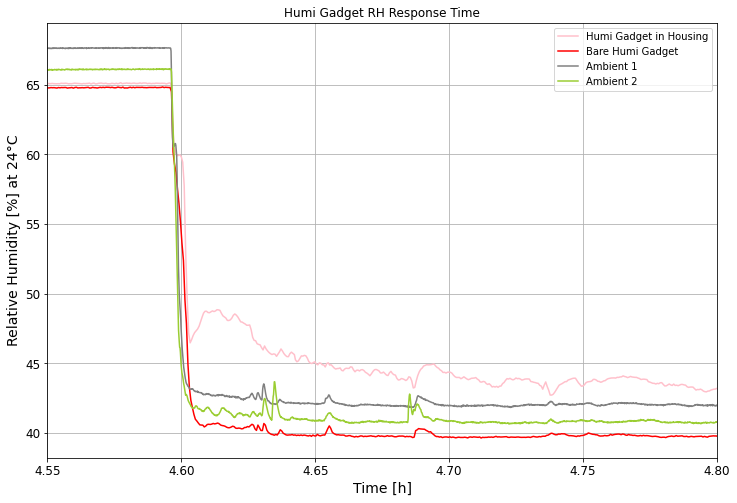

In [3]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.set_title('Humi Gadget RH Response Time')
# ax.fill_between(DM.Epoch_UTC/3600, DM.T_DewPointMirror - 0.5, DM.T_DewPointMirror + 0.5, facecolor='blue', alpha=0.1)
# ax.plot(DM.Epoch_UTC/3600, DM.T_DewPointMirror, color = 'blue')
ax.plot(HumiGadget.Epoch_UTC/3600, HumiGadget['RH'], color = 'pink')
ax.plot(HumiGadgetbare.Epoch_UTC/3600, HumiGadgetbare['RH'], color = 'red')
ax.plot(amb1.Epoch_UTC/3600, amb1.RH_SHT4x_279916703, color = 'grey')
ax.plot(amb2.Epoch_UTC/3600, amb2.RH_SHT4x_279922293, color = 'yellowgreen')

ax.set_ylabel('Relative Humidity [%] at 24°C', fontsize=14)
ax.set_xlabel('Time [h]', fontsize=14)
# ax.set_ylim(15,28)
ax.set_xlim(4.55,4.8)
ax.legend(['Humi Gadget in Housing','Bare Humi Gadget','Ambient 1','Ambient 2'],loc='upper right')
ax.tick_params(labelsize=12)
ax.grid()

## Response Time

In [4]:
responseStart = True
averageResponse = mean(amb1.RH_SHT4x_279916703.where(amb1.Epoch_UTC/3600 > 4.8).dropna())
DMRH =  mean(amb1.RH_SHT4x_279916703.where(amb1.Epoch_UTC/3600 < 4.4).dropna())

for i in range(0, amb2.shape[0]):
    if amb2.iloc[i,3] < DMRH*0.9 and responseStart == True:
        responseStart = False
        StartTime = amb2.iloc[i,0] # Time when the response starts where the temperature changes
        # print(Start/3600)
    if amb2.iloc[i,3] < (averageResponse - DMRH)*0.63 + DMRH:
        End = amb2.iloc[i,0] #Epoch Time when the temperature has reached roughly the ambient temperature
        # print(End/3600)
        break
ResponseTimebare = End - StartTime
# print(averageResponse)
print("Response Time of the flex SHT [s]:")
print(ResponseTimebare) 

responseStart = True
for i in range(0, HumiGadgetbare.shape[0]):
    # if HumiGadgetbare.iloc[i,2] > DMTemperature*1.1 and responseStart == True:
        # responseStart = False
        # Start = HumiGadgetbare.iloc[i,0] # Time when the response starts where the temperature changes
        # print(Start/3600)
    if HumiGadgetbare.iloc[i,3] < (averageResponse - DMRH)*0.63 + DMRH:
        End = HumiGadgetbare.iloc[i,0] #Epoch Time when the temperature has reached roughly the ambient temperature
        # print(End/3600)
        break
ResponseTimebare = End - StartTime
# print(averageResponse)
print("Response Time of the bare Humi Gadget [s]:")
print(ResponseTimebare)

responseStart = True
for i in range(0, HumiGadget.shape[0]):
    if HumiGadget.iloc[i,3] < (averageResponse - DMRH)*0.63 + DMRH:
        End = HumiGadget.iloc[i,0] #Epoch Time when the temperature has reached roughly the ambient temperature
        # print(End/3600)
        break
ResponseTime = End - StartTime
# print(averageResponse)
print("Response Time of the Humi Gadget in the housing [s]:")
print(ResponseTime)

Response Time of the flex SHT [s]:
5.0
Response Time of the bare Humi Gadget [s]:
15.099999904632568
Response Time of the Humi Gadget in the housing [s]:
18.09999990463257
